This method works as follows:

1. The covariance we compute is as follows.
    a. We elementwise multiply the current and previous weight biases and call these the current expectation estimates of weights + biases.
    b. We elementwise multiply the normalized mean vector of the output batch with the normalized mean of the previous output batch to compute a cosine similarity.
    c. We update 3 values, `Ewz`, `Ebz`, `Ez`, `Ew`, `Eb` which are all exponential moving averages with `Ewz`/`Ebz` being the product of value calculated in (a) with the value calculated in (b) and `Ez` being on (b) and `Ew`/`Eb` being only (a).
2. The quantities `Ewz - EwEz` and `Ebz-EbEz` are treated as kernel covariances and their value define parameter level `eta` values.
3. `eta` values computed in (2) are multiplied by global eta and scale the contribution of a unit Ornstein-Uhlenbeck process `process` to the gradient dynamics which is normally governed by batched SGD.

The cell below runs a simple grid search on the proposed algorithm.

The way that this is supposed to work *theoretically* is that we're computing a very light-weight relative of cosine similarity HSIC between individual parameters and output vectors of layers - which is a very strained independence test on the two which basically amounts to computing the covariance between the cosine similarity of inter-batch output mean vectors and "cosine similarity" between layer parameters.

Matter of fact is that most mathematically pretty probes chug in real life - and yes, that does make them inadequate.

Natural next questions are:

1. What happens if we change this methods from look at outputs to inputs?
2. Is there a better way that we can capture the "covariance of kernel deltas" without resorting to means?
3. What are the effects that this has mathematically - can we in any reasonable sense say that we are talking about information?

KeyboardInterrupt: 

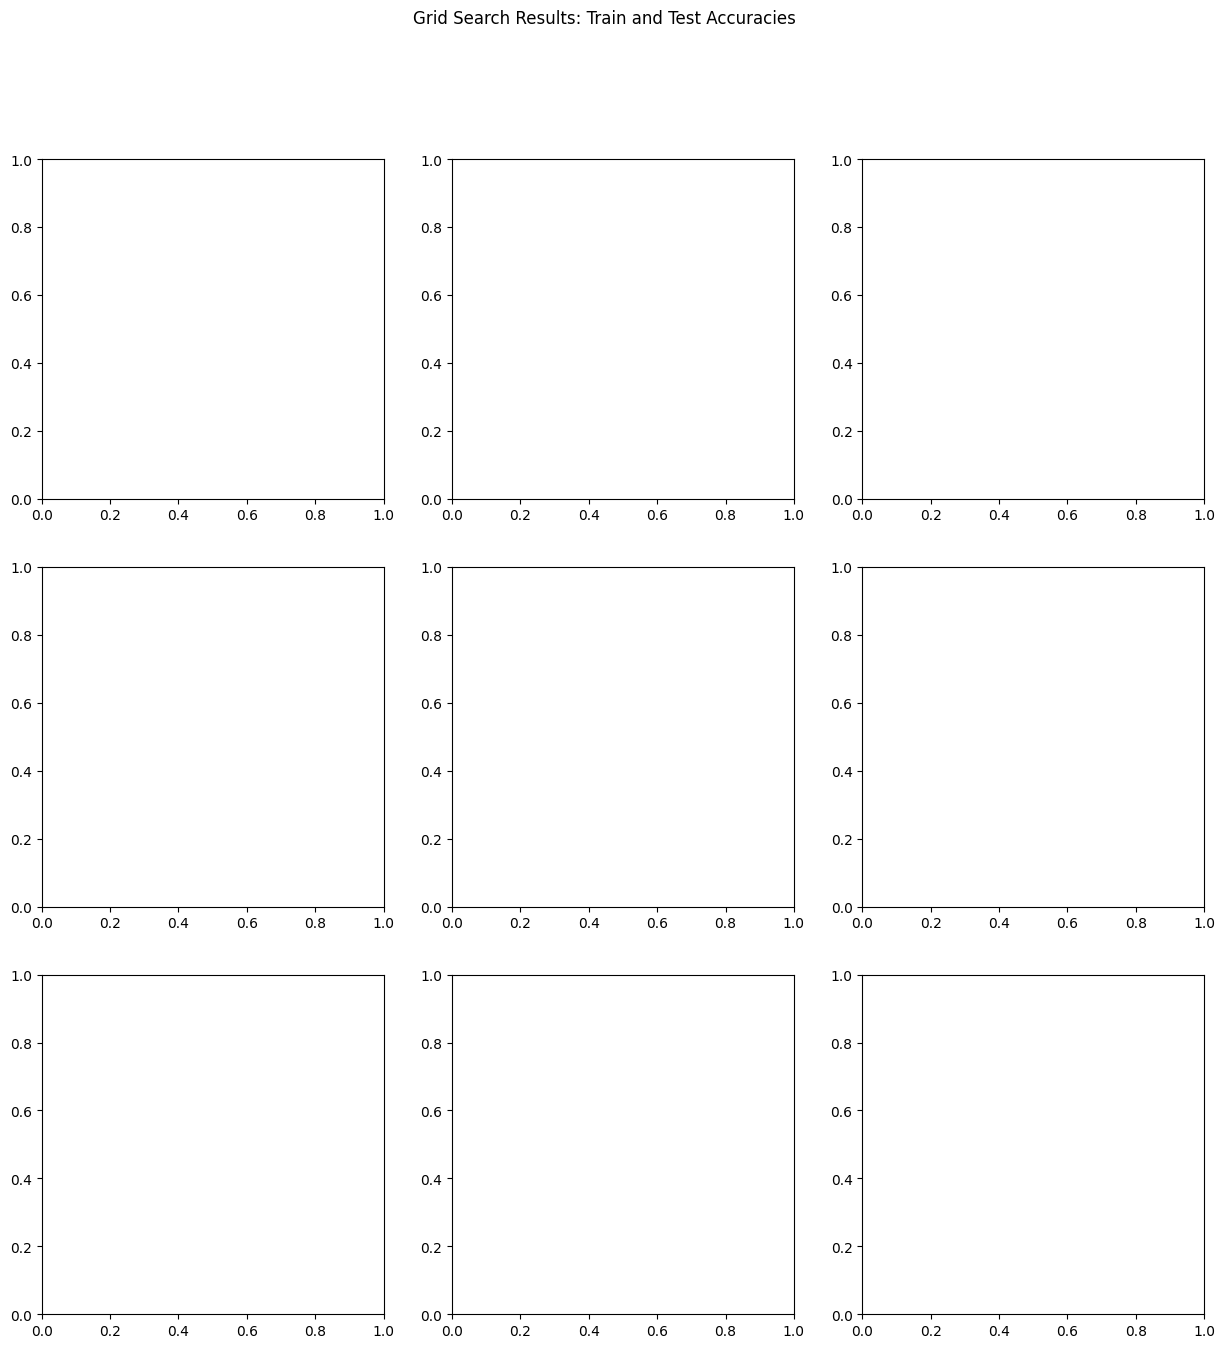

In [38]:


class ForgetLayer(nn.Module):
    def __init__(self, input_size, output_size, activation, gamma, epsilon, eta, process, device):
        super(ForgetLayer, self).__init__()
        self.device = device
        self.weights = nn.Parameter(torch.randn(output_size, input_size, device=device))
        self.biases = nn.Parameter(torch.randn(output_size, device=device))
        self.activation = activation
        self.gamma = gamma
        self.epsilon = epsilon
        self.eta = eta
        self.process = process

        self.Ezw = torch.zeros(output_size, input_size, device=device)
        self.Ew = torch.zeros(output_size, input_size, device=device)
        self.Ezb = torch.zeros(output_size, device=device)
        self.Eb = torch.zeros(output_size, device=device)
        self.Ez = torch.zeros(1, device=device)

        self.prev_w = torch.zeros(output_size, input_size, device=device)
        self.prev_b = torch.zeros(output_size, device=device)
        self.prev_z = None

        self.eta_w = torch.zeros(output_size, input_size, device=device)
        self.eta_b = torch.zeros(output_size, device=device)

    def forward(self, x, eval=False):
        z = F.linear(x, self.weights, self.biases)
        activated_z = self.activation(z)
        if not eval:
            self.update_moving_averages(activated_z)
            self.compute_eta()
        return activated_z

    def update_moving_averages(self, z):
        if self.prev_z is None:
            self.prev_z = z.detach().mean(0)
            return

        z_mean = z.mean(0)
        delta_kz = F.cosine_similarity(z_mean, self.prev_z, dim=0)
        delta_kw = self.weights * self.prev_w
        delta_kb = self.biases * self.prev_b
        delta_kzw = delta_kz * delta_kw
        delta_kzb = delta_kz * delta_kb

        self.Ezw = (1 - self.gamma) * self.Ezw + self.gamma * delta_kzw
        self.Ezb = (1 - self.gamma) * self.Ezb + self.gamma * delta_kzb
        self.Ew = (1 - self.gamma) * self.Ew + self.gamma * delta_kw
        self.Ez = (1 - self.gamma) * self.Ez + self.gamma * delta_kz.mean()
        self.Eb = (1 - self.gamma) * self.Eb + self.gamma * delta_kb

        self.prev_w = self.weights.detach()
        self.prev_b = self.biases.detach()
        self.prev_z = z_mean.detach()

    def compute_eta(self):
        self.eta_w = self.eta * torch.abs(self.Ezw - self.Ez * self.Ew)
        self.eta_b = self.eta * torch.abs(self.Ezb - self.Ez * self.Eb)

    def update_parameters(self, dLdW, dLdb):
        with torch.no_grad():
            self.weights += -self.epsilon * dLdW + self.eta_w * self.process(self.weights)
            self.biases += -self.epsilon * dLdb + self.eta_b * self.process(self.biases)

class ForgetNetwork(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size, activations, gamma, epsilon, eta, process, device):
        super(ForgetNetwork, self).__init__()
        self.layers = nn.ModuleList()

        for idx, layer_size in enumerate(layer_sizes):
            if idx == 0:
                self.layers.append(ForgetLayer(input_size, layer_size, activations[idx], gamma, epsilon, eta, process, device))
            elif idx == len(layer_sizes) - 1:
                self.layers.append(ForgetLayer(layer_sizes[idx-1], output_size, activations[idx], gamma, epsilon, eta, process, device))
            else:
                self.layers.append(ForgetLayer(layer_sizes[idx-1], layer_size, activations[idx], gamma, epsilon, eta, process, device))

    def forward(self, x, eval=False):
        for layer in self.layers:
            x = layer(x, eval=eval)
        return x



if __name__ == '__main__':
    main("output-parameter-rif.png")

Modifiying it to be like the above algorithm but instead passing the layer input to the `update_parameters` command.

Grid Search Progress: 100%|██████████| 27/27 [2:45:13<00:00, 367.16s/it, η=0.1, γ=0.1, ε=0.1]      


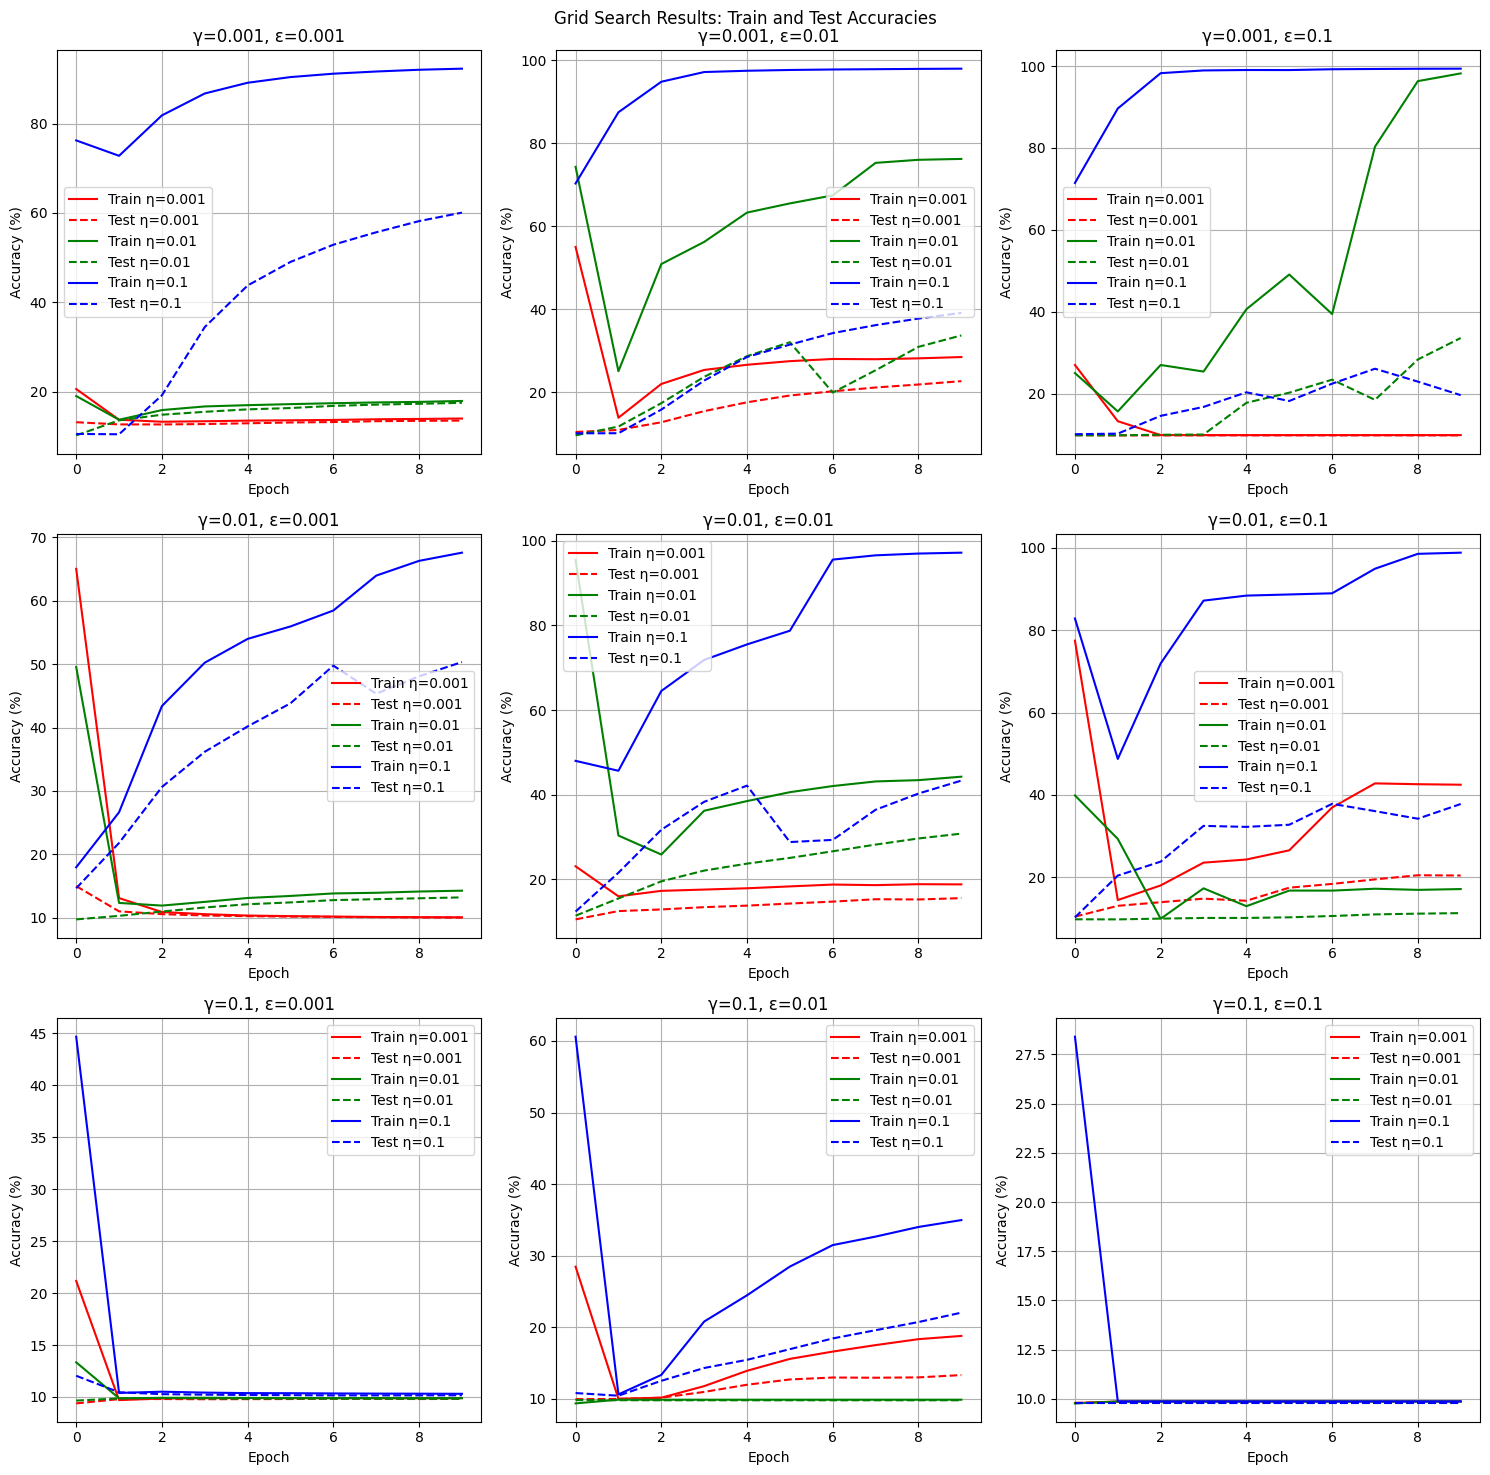

In [13]:
class ForgetLayer(nn.Module):
    def __init__(self, input_size, output_size, activation, gamma, epsilon, eta, process, device):
        super(ForgetLayer, self).__init__()
        self.device = device
        self.weights = nn.Parameter(torch.randn(output_size, input_size, device=device))
        self.biases = nn.Parameter(torch.randn(output_size, device=device))
        self.activation = activation
        self.gamma = gamma
        self.epsilon = epsilon
        self.eta = eta
        self.process = process

        self.Ezw = torch.zeros(output_size, input_size, device=device)
        self.Ew = torch.zeros(output_size, input_size, device=device)
        self.Ezb = torch.zeros(output_size, device=device)
        self.Eb = torch.zeros(output_size, device=device)
        self.Ez = torch.zeros(1, device=device)

        self.prev_w = torch.zeros(output_size, input_size, device=device)
        self.prev_b = torch.zeros(output_size, device=device)
        self.prev_z = None

        self.eta_w = torch.zeros(output_size, input_size, device=device)
        self.eta_b = torch.zeros(output_size, device=device)

    def forward(self, x, eval=False):
        z = F.linear(x, self.weights, self.biases)
        activated_z = self.activation(z)
        if not eval:
            self.update_moving_averages(activated_z)
            self.compute_eta()
        return activated_z

    def update_moving_averages(self, z):
        if self.prev_z is None:
            self.prev_z = z.detach().mean(0)
            return

        z_mean = z.mean(0)
        delta_kz = F.cosine_similarity(z_mean, self.prev_z, dim=0)
        delta_kw = self.weights * self.prev_w
        delta_kb = self.biases * self.prev_b
        delta_kzw = delta_kz * delta_kw
        delta_kzb = delta_kz * delta_kb

        self.Ezw = (1 - self.gamma) * self.Ezw + self.gamma * delta_kzw
        self.Ezb = (1 - self.gamma) * self.Ezb + self.gamma * delta_kzb
        self.Ew = (1 - self.gamma) * self.Ew + self.gamma * delta_kw
        self.Ez = (1 - self.gamma) * self.Ez + self.gamma * delta_kz.mean()
        self.Eb = (1 - self.gamma) * self.Eb + self.gamma * delta_kb

        self.prev_w = self.weights.detach()
        self.prev_b = self.biases.detach()
        self.prev_z = z_mean.detach()

    def compute_eta(self):
        self.eta_w = self.eta * torch.abs(self.Ezw - self.Ez * self.Ew)
        self.eta_b = self.eta * torch.abs(self.Ezb - self.Ez * self.Eb)

    def update_parameters(self, dLdW, dLdb):
        with torch.no_grad():
            self.weights += -self.epsilon * dLdW + self.eta_w * self.process(self.weights)
            self.biases += -self.epsilon * dLdb + self.eta_b * self.process(self.biases)

if __name__ == '__main__':
    main("input-parameter-rif.png")

This experiment changes the process to determine the kernel delta covariance into a more explicit per batch measure, it works something like this:

1. Do not store any expectations but we will store the eta_w and eta_b
2. On gradient descent do add the OU process
3. To compute the kernel delta covariance - we create a stack of weight vectors each perturbed by Gaussian noise with variance given by eta_w and eta_b for weights and biases, respectively. Following this we want to following algorithm:
    1. Take the weight tensor, and multiply it by itself shifted by one index in the sample axis - this forms the weight kernel delta tensor.
    2. Similarly take the input batch, shift it by one and then take dot-products, leaving behind a vector in the sample axis, the input kernel delta vector.
    3. To compute Ewz we multiply in the sample axis the weight kernel delta tensor and then take its empirical mean in the sample axis.
    4. Likewise for Ew and Ez - take empirical means of the weight kernel delta tensor and the input kernel delta vector.
    5. Finally, compute the covariance by using elementwise multiplication on the expression Ewz-EwEz

The experiment is a response to what I think is the discovry above of what could conceivably be called a "Retrieval-Inference Forgetting" mechanism rather than a true to life parameter information bottleneck minimizer - to really get at this, the next experiment will probably be an explicit regularizer.


Experiment 1/9: η=0.001, ε=0.001



Experiment 2/9: η=0.001, ε=0.01



Experiment 3/9: η=0.001, ε=0.1



Experiment 4/9: η=0.01, ε=0.001



Experiment 5/9: η=0.01, ε=0.01



Experiment 6/9: η=0.01, ε=0.1



Experiment 7/9: η=0.1, ε=0.001



Experiment 8/9: η=0.1, ε=0.01



Experiment 9/9: η=0.1, ε=0.1


Grid Search Progress: 100%|██████████| 9/9 [12:36<00:00, 84.02s/it, η=0.1, ε=0.1]


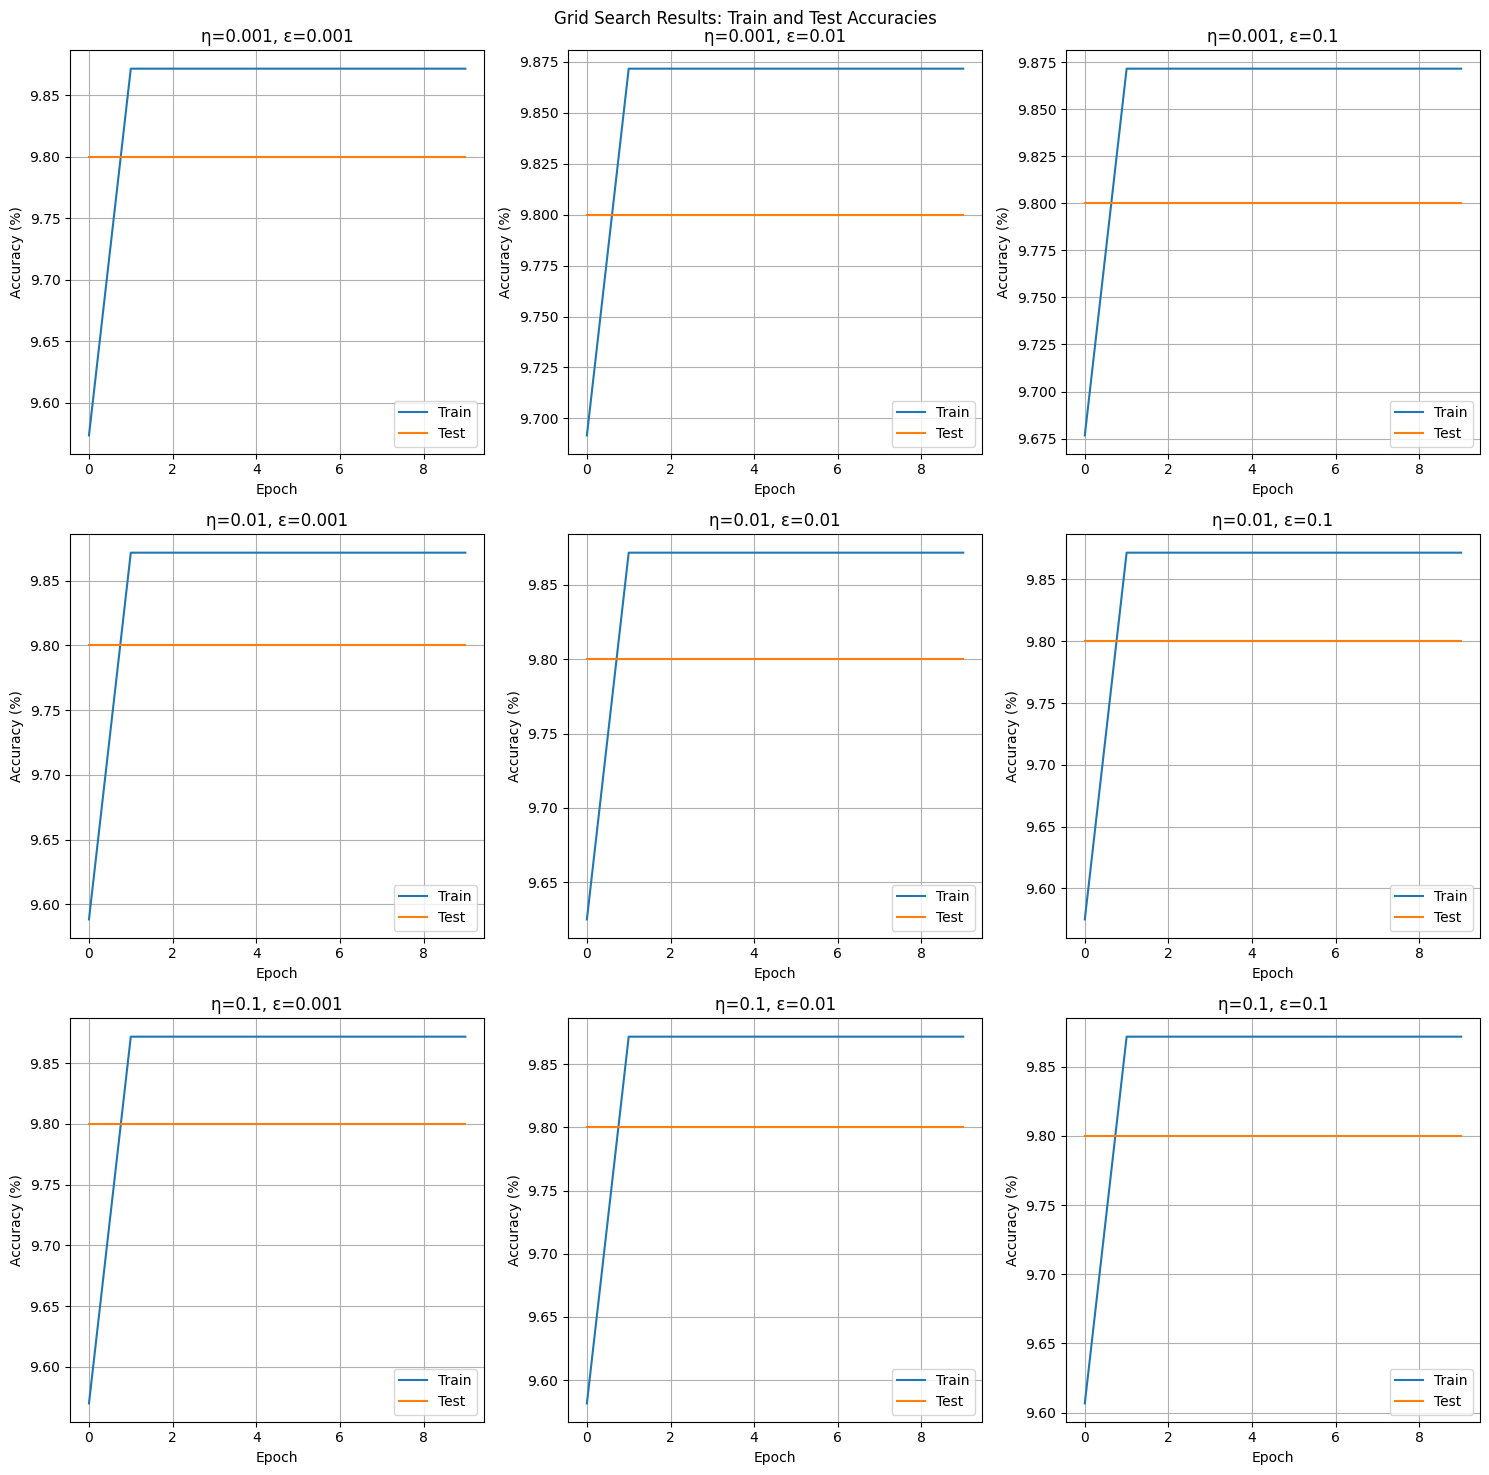

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

class ForgetLayer(nn.Module):

    def __init__(self, input_size, output_size, activation, gamma, epsilon, eta, process, device):

        super(ForgetLayer, self).__init__()
        self.device = device
        self.weights = nn.Parameter(torch.randn(output_size, input_size, device=device))
        self.biases = nn.Parameter(torch.randn(output_size, device=device))
        self.activation = activation
        self.epsilon = epsilon
        self.eta = eta
        self.process = process

        self.prev_weights = self.weights.clone().detach()
        self.prev_biases = self.biases.clone().detach()
        self.eta_w = torch.zeros_like(self.weights)
        self.eta_b = torch.zeros_like(self.biases)

    def forward(self, x, eval=False):
        
        z = F.linear(x, self.weights, self.biases)
        activated_z = self.activation(z)
        if not eval:
            self.compute_kernel_delta_covariance(activated_z)

        return activated_z

    def compute_kernel_delta_covariance(self, x):

        with torch.no_grad():

            batch_size = x.shape[0]
            
            # Create perturbed weight and bias tensors
            noise_w = self.eta_w * torch.randn(batch_size, *self.weights.shape, device=self.device)
            noise_b = self.eta_b * torch.randn(batch_size, *self.biases.shape, device=self.device)
            
            perturbed_weights = self.weights.unsqueeze(0).expand(batch_size, -1, -1) + noise_w * self.eta_w.unsqueeze(0)
            perturbed_biases = self.biases.unsqueeze(0).expand(batch_size, -1) + noise_b * self.eta_b.unsqueeze(0)
            
            # Compute weight kernel delta tensor
            weight_kernel_delta = perturbed_weights[1:] * perturbed_weights[:-1]
            bias_kernel_delta = perturbed_biases[1:] * perturbed_biases[:-1]
            
            # Compute input kernel delta vector
            input_kernel_delta = torch.sum(x[1:] * x[:-1], dim=1)
            
            # Compute Ewx and Ebx
            Ewx = torch.einsum('ijk,i->jk', weight_kernel_delta, input_kernel_delta) / batch_size
            Ebx = torch.einsum('ij,i->j', bias_kernel_delta, input_kernel_delta) / batch_size

            # Compute Ew and Ez
            Ew = torch.mean(weight_kernel_delta, dim = 0)
            Ex = torch.mean(input_kernel_delta)
            Eb = torch.mean(bias_kernel_delta, dim = 0)
            
            # Compute covariance
            cov_w = Ewx - Ew * Ex
            cov_b = Ebx - Eb * Ex
            
            # Update eta values
            self.eta_w = self.eta * torch.abs(cov_w)
            self.eta_b = self.eta * torch.abs(cov_b)

    def update_parameters(self, dLdW, dLdb):
        with torch.no_grad():
            # Add only the deterministic component of the OU process
            ou_process_w = self.process(self.weights)
            ou_process_b = self.process(self.biases)
            
            self.weights += -self.epsilon * dLdW + self.eta * self.eta_w * ou_process_w
            self.biases += -self.epsilon * dLdb + self.eta * self.eta_b * ou_process_b
            
            # Store current weights and biases for the next iteration
            self.prev_weights = self.weights.clone().detach()
            self.prev_biases = self.biases.clone().detach()

def main(plot_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set up grid search parameters
    etas = [10**i for i in range(-3, 0)]
    # gammas = [1e-3, 1e-2, 1e-1]
    epsilons =  [10**i for i in range(-3, 0)]
    
    # Set up the plot
    fig, axs = plt.subplots(len(etas), len(epsilons), figsize=(15, 15))
    fig.suptitle("Grid Search Results: Train and Test Accuracies")
    
    # Run experiments
    total_experiments = len(etas) * len(epsilons)
    epochs = 10
    
    pbar = tqdm(total=total_experiments, desc="Grid Search Progress")
    
    for i, (eta,  epsilon) in enumerate(itertools.product(etas, epsilons)):
        print(f"\nExperiment {i+1}/{total_experiments}: η={eta}, ε={epsilon}")
        train_accs, test_accs = run_experiment(eta, 0, epsilon, device, epochs=epochs)
        
        # Plot results
        ax = axs[i // len(etas), i % len(epsilons)]
        ax.plot(train_accs, label=f'Train')
        ax.plot(test_accs, label=f'Test')
        ax.set_title(f'η={eta}, ε={epsilon}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)
        
        pbar.update(1)
        pbar.set_postfix({'η': eta, 'ε': epsilon})
    
    pbar.close()
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

if __name__ == '__main__':
    main("output-parameter-static-batch.png")

What if we just focus on the correlated/anticorrelated regions?


Experiment 1/1: η=0.1, ε=0.1




Grid Search Progress: 100%|██████████| 1/1 [05:25<00:00, 325.73s/it, η=0.1, ε=0.1]


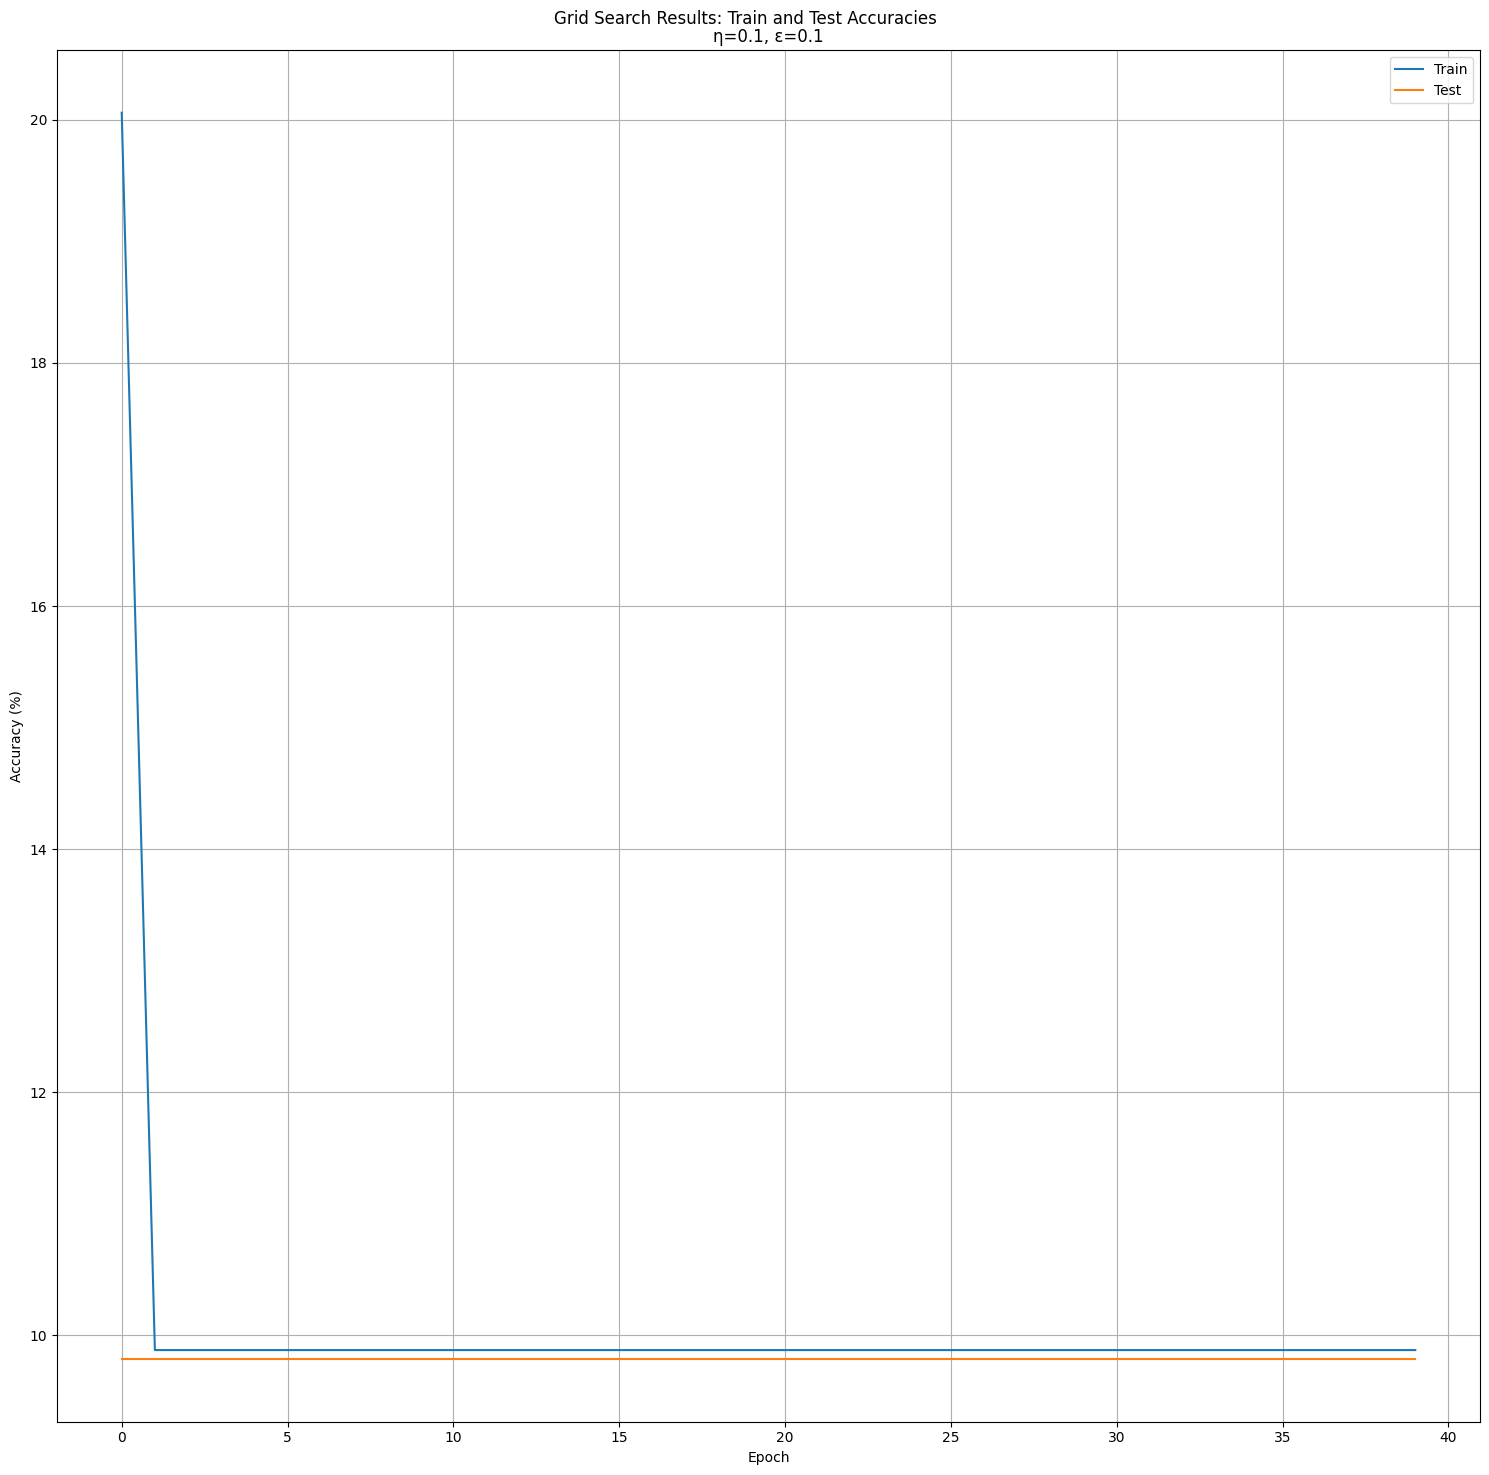

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

class ForgetLayer(nn.Module):

    def __init__(self, input_size, output_size, activation, gamma, epsilon, eta, process, device):

        super(ForgetLayer, self).__init__()
        self.device = device
        self.weights = nn.Parameter(torch.randn(output_size, input_size, device=device))
        self.biases = nn.Parameter(torch.randn(output_size, device=device))
        self.activation = activation
        self.epsilon = epsilon
        self.eta = eta
        self.process = process

        self.prev_weights = self.weights.clone().detach()
        self.prev_biases = self.biases.clone().detach()
        self.eta_w = torch.zeros_like(self.weights)
        self.eta_b = torch.zeros_like(self.biases)

    def forward(self, x, eval=False):
        
        z = F.linear(x, self.weights, self.biases)
        activated_z = self.activation(z)
        if not eval:
            self.compute_kernel_delta_covariance(activated_z)

        return activated_z

    def compute_kernel_delta_covariance(self, x):

        with torch.no_grad():

            batch_size = x.shape[0]
            
            # Create perturbed weight and bias tensors
            noise_w = self.eta_w * torch.randn(batch_size, *self.weights.shape, device=self.device)
            noise_b = self.eta_b * torch.randn(batch_size, *self.biases.shape, device=self.device)
            
            perturbed_weights = self.weights.unsqueeze(0).expand(batch_size, -1, -1) + noise_w * self.eta_w.unsqueeze(0)
            perturbed_biases = self.biases.unsqueeze(0).expand(batch_size, -1) + noise_b * self.eta_b.unsqueeze(0)
            
            # Compute weight kernel delta tensor
            weight_kernel_delta = perturbed_weights[1:] * perturbed_weights[:-1]
            bias_kernel_delta = perturbed_biases[1:] * perturbed_biases[:-1]
            
            # Compute input kernel delta vector
            input_kernel_delta = torch.sum(x[1:] * x[:-1], dim=1)
            
            # Compute Ewx and Ebx
            Ewx = torch.einsum('ijk,i->jk', weight_kernel_delta, input_kernel_delta) / batch_size
            Ebx = torch.einsum('ij,i->j', bias_kernel_delta, input_kernel_delta) / batch_size

            # Compute Ew and Ez
            Ew = torch.mean(weight_kernel_delta, dim = 0)
            Ex = torch.mean(input_kernel_delta)
            Eb = torch.mean(bias_kernel_delta, dim = 0)
            
            # Compute covariance
            cov_w = Ewx - Ew * Ex
            cov_b = Ebx - Eb * Ex
            
            # Update eta values
            self.eta_w = self.eta * F.relu(cov_w)
            self.eta_b = self.eta * F.relu(cov_b)

    def update_parameters(self, dLdW, dLdb):
        with torch.no_grad():
            # Add only the deterministic component of the OU process
            ou_process_w = self.process(self.weights)
            ou_process_b = self.process(self.biases)
            
            self.weights += -self.epsilon * dLdW + self.eta * self.eta_w * ou_process_w
            self.biases += -self.epsilon * dLdb + self.eta * self.eta_b * ou_process_b
            
            # Store current weights and biases for the next iteration
            self.prev_weights = self.weights.clone().detach()
            self.prev_biases = self.biases.clone().detach()

def main(plot_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set up grid search parameters
    etas = [10**i for i in range(-1, 0)]
    # gammas = [1e-3, 1e-2, 1e-1]
    epsilons =  [10**i for i in range(-1, 0)]
    
    # Set up the plot
    fig, axs = plt.subplots(len(etas), len(epsilons), figsize=(15, 15))
    fig.suptitle("Grid Search Results: Train and Test Accuracies")
    
    # Run experiments
    total_experiments = len(etas) * len(epsilons)
    epochs = 40
    
    pbar = tqdm(total=total_experiments, desc="Grid Search Progress")
    
    for i, (eta,  epsilon) in enumerate(itertools.product(etas, epsilons)):
        print(f"\nExperiment {i+1}/{total_experiments}: η={eta}, ε={epsilon}")
        train_accs, test_accs = run_experiment(eta, 0, epsilon, device, epochs=epochs)
        
        # Plot results
        # ax = axs[i // len(etas), i % len(epsilons)]

        ax = axs
        ax.plot(train_accs, label=f'Train')
        ax.plot(test_accs, label=f'Test')
        ax.set_title(f'η={eta}, ε={epsilon}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)
        
        pbar.update(1)
        pbar.set_postfix({'η': eta, 'ε': epsilon})
    
    pbar.close()
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

if __name__ == '__main__':
    main("input-parameter-correlated-batch3.png")

Above's methods using cosine similarity.


Experiment 1/9: η=0.001, ε=0.001



Experiment 2/9: η=0.001, ε=0.01



Experiment 3/9: η=0.001, ε=0.1



Experiment 4/9: η=0.01, ε=0.001



Experiment 5/9: η=0.01, ε=0.01



Experiment 6/9: η=0.01, ε=0.1



Experiment 7/9: η=0.1, ε=0.001



Experiment 8/9: η=0.1, ε=0.01



Experiment 9/9: η=0.1, ε=0.1




Grid Search Progress: 100%|██████████| 9/9 [12:59<00:00, 86.57s/it, η=0.1, ε=0.1]


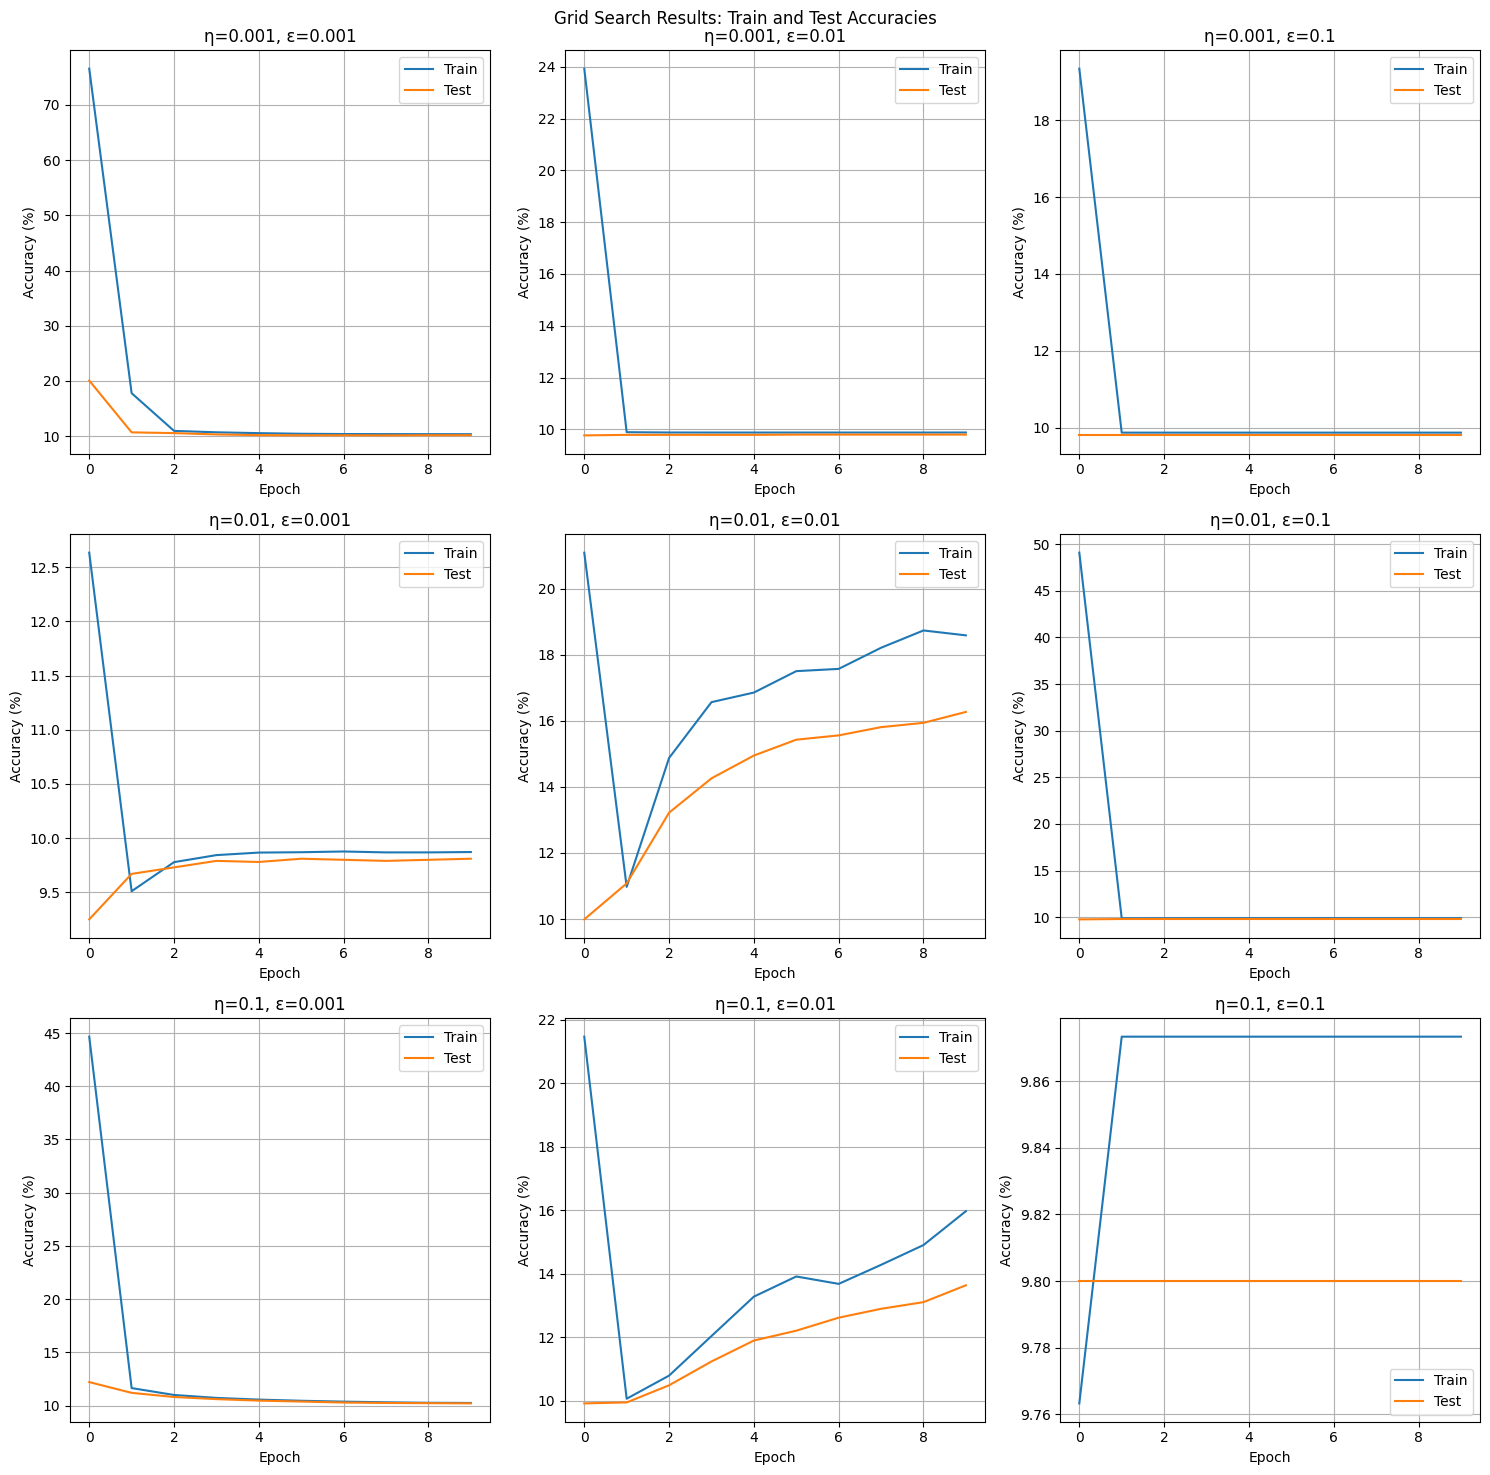

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

class ForgetLayer(nn.Module):

    def __init__(self, input_size, output_size, activation, gamma, epsilon, eta, process, device):

        super(ForgetLayer, self).__init__()
        self.device = device
        self.weights = nn.Parameter(torch.randn(output_size, input_size, device=device))
        self.biases = nn.Parameter(torch.randn(output_size, device=device))
        self.activation = activation
        self.epsilon = epsilon
        self.eta = eta
        self.process = process

        self.prev_weights = self.weights.clone().detach()
        self.prev_biases = self.biases.clone().detach()
        self.eta_w = torch.zeros_like(self.weights)
        self.eta_b = torch.zeros_like(self.biases)

    def forward(self, x, eval=False):
        
        z = F.linear(x, self.weights, self.biases)
        activated_z = self.activation(z)
        if not eval:
            self.compute_kernel_delta_covariance(x)

        return activated_z

    def compute_kernel_delta_covariance(self, x):

        with torch.no_grad():

            batch_size = x.shape[0]
            
            # Create perturbed weight and bias tensors
            noise_w = self.eta_w * torch.randn(batch_size, *self.weights.shape, device=self.device)
            noise_b = self.eta_b * torch.randn(batch_size, *self.biases.shape, device=self.device)

            perturbed_weights = self.weights.unsqueeze(0).expand(batch_size, -1, -1) + (noise_w * self.eta_w.unsqueeze(0))
            perturbed_biases = self.biases.unsqueeze(0).expand(batch_size, -1) + (noise_b * self.eta_b.unsqueeze(0))

            perturbed_weights = F.normalize(perturbed_weights, p=2, dim=(1,2))
            perturbed_biases = F.normalize(perturbed_biases, p=2, dim=1)
            normed_x = F.normalize(x, p=2, dim=1)

            # Compute weight kernel delta tensor
            weight_kernel_delta = perturbed_weights[1:] * perturbed_weights[:-1]
            bias_kernel_delta = perturbed_biases[1:] * perturbed_biases[:-1]
            
            # Compute input kernel delta vector
            input_kernel_delta = torch.sum(normed_x[1:] * normed_x[:-1], dim=1)
            
            # Compute Ewx and Ebx
            Ewx = torch.einsum('ijk,i->jk', weight_kernel_delta, input_kernel_delta) / batch_size
            Ebx = torch.einsum('ij,i->j', bias_kernel_delta, input_kernel_delta) / batch_size

            # Compute Ew and Ez
            Ew = torch.mean(weight_kernel_delta, dim = 0)
            Ex = torch.mean(input_kernel_delta)
            Eb = torch.mean(bias_kernel_delta, dim = 0)
            
            # Compute covariance
            cov_w = Ewx - Ew * Ex
            cov_b = Ebx - Eb * Ex
            
            # Update eta values
            self.eta_w = self.eta * cov_w
            self.eta_b = self.eta * cov_b

    def update_parameters(self, dLdW, dLdb):
        with torch.no_grad():
            # Add only the deterministic component of the OU process
            ou_process_w = self.process(self.weights)
            ou_process_b = self.process(self.biases)
            
            self.weights += -self.epsilon * dLdW + self.eta * self.eta_w * ou_process_w
            self.biases += -self.epsilon * dLdb + self.eta * self.eta_b * ou_process_b
            
            # Store current weights and biases for the next iteration
            self.prev_weights = self.weights.clone().detach()
            self.prev_biases = self.biases.clone().detach()

def main(plot_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set up grid search parameters
    etas = [10**i for i in range(-3, 0)]
    # gammas = [1e-3, 1e-2, 1e-1]
    epsilons =  [10**i for i in range(-3, 0)]
    
    # Set up the plot
    fig, axs = plt.subplots(len(etas), len(epsilons), figsize=(15, 15))
    fig.suptitle("Grid Search Results: Train and Test Accuracies")
    
    # Run experiments
    total_experiments = len(etas) * len(epsilons)
    epochs = 10
    
    pbar = tqdm(total=total_experiments, desc="Grid Search Progress")
    
    for i, (eta,  epsilon) in enumerate(itertools.product(etas, epsilons)):
        print(f"\nExperiment {i+1}/{total_experiments}: η={eta}, ε={epsilon}")
        train_accs, test_accs = run_experiment(eta, 0, epsilon, device, epochs=epochs)
        
        # Plot results
        ax = axs[i // len(etas), i % len(epsilons)]
        ax.plot(train_accs, label=f'Train')
        ax.plot(test_accs, label=f'Test')
        ax.set_title(f'η={eta}, ε={epsilon}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)
        
        pbar.update(1)
        pbar.set_postfix({'η': eta, 'ε': epsilon})
    
    pbar.close()
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

if __name__ == '__main__':
    main("input-parameter-cosine-batch2.png")

Now with a Gaussian kernel


Experiment 1/9: η=0.001, ε=0.001



Experiment 2/9: η=0.001, ε=0.01



Experiment 3/9: η=0.001, ε=0.1



Experiment 4/9: η=0.01, ε=0.001



Experiment 5/9: η=0.01, ε=0.01



Experiment 6/9: η=0.01, ε=0.1



Experiment 7/9: η=0.1, ε=0.001



Experiment 8/9: η=0.1, ε=0.01



Experiment 9/9: η=0.1, ε=0.1




Grid Search Progress:   0%|          | 0/9 [4:00:47<?, ?it/s]


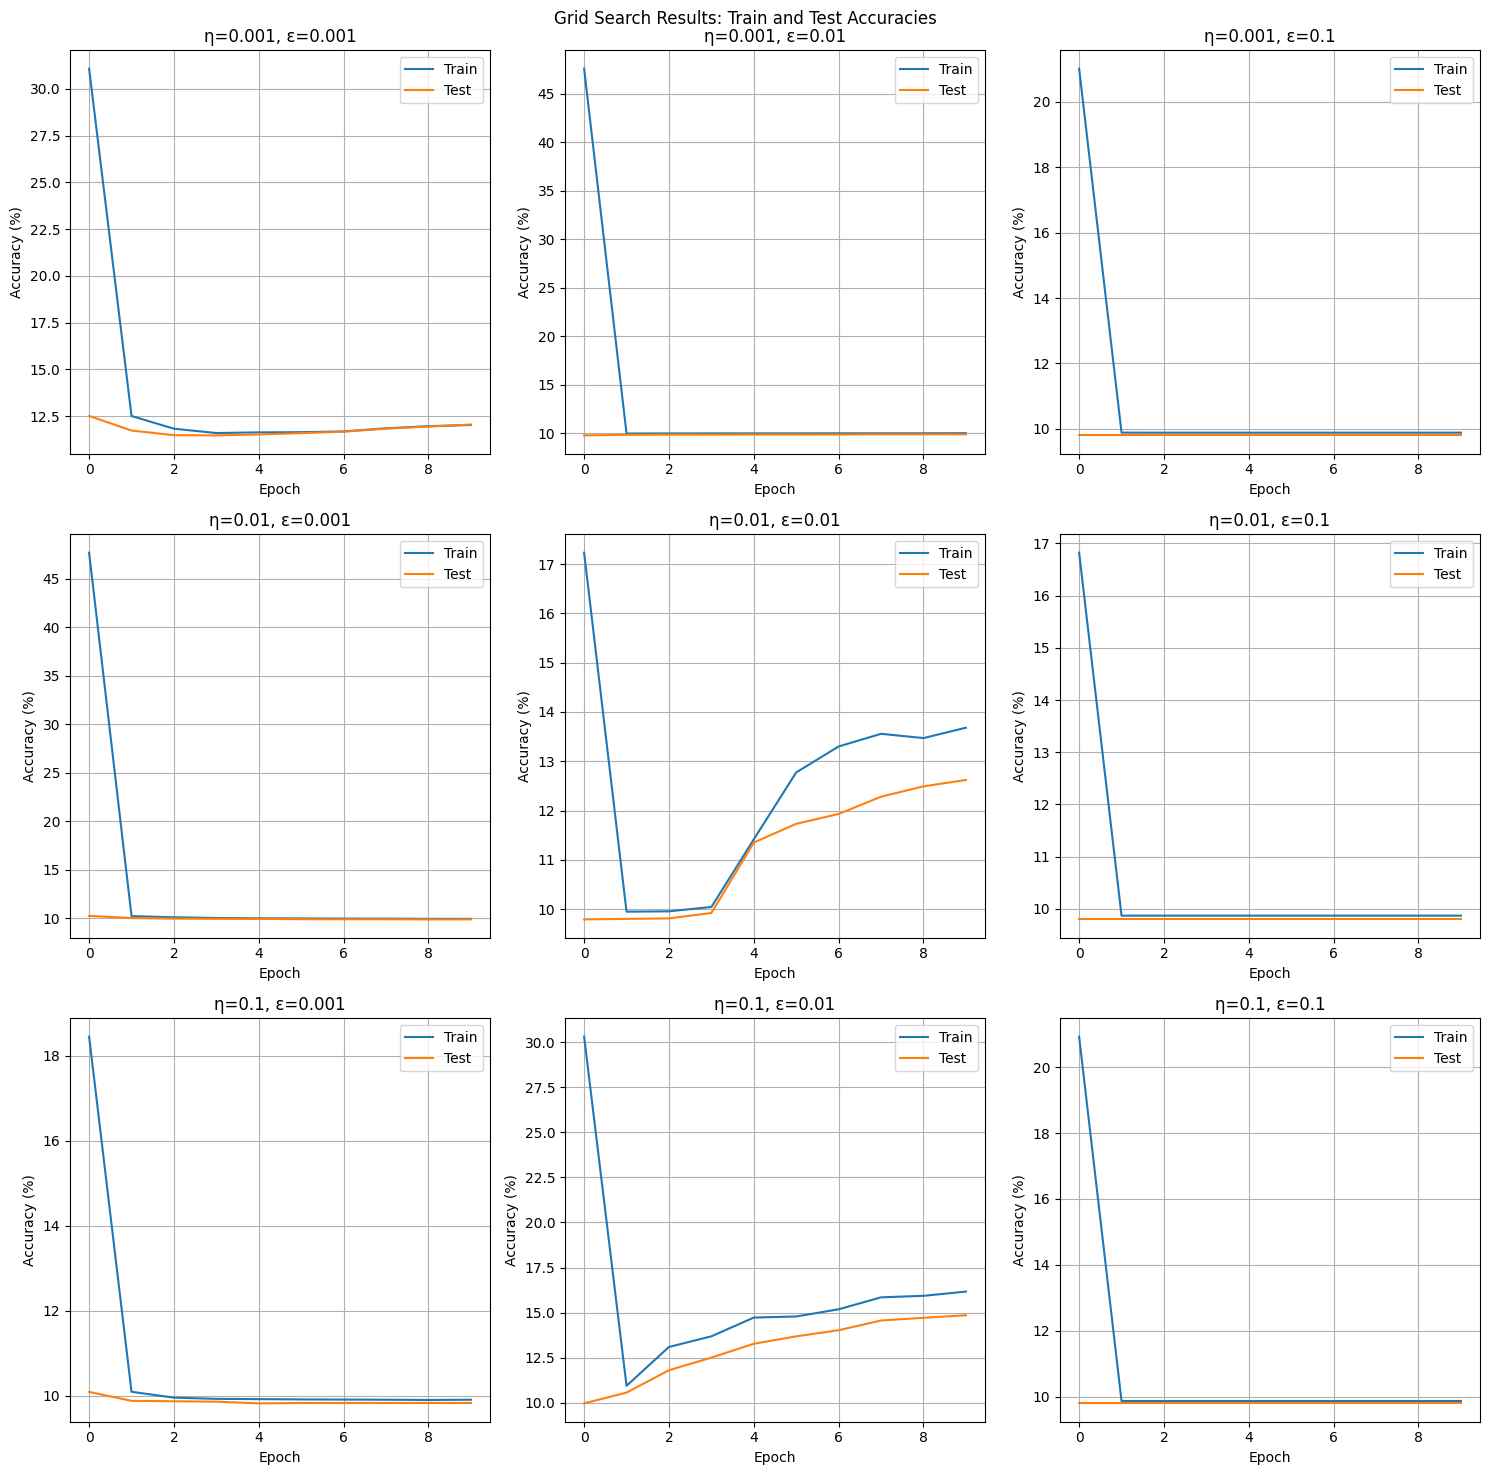

In [41]:
class ForgetLayer(nn.Module):

    def __init__(self, input_size, output_size, activation, gamma, epsilon, eta, process, device, sigma=1.0):
        super(ForgetLayer, self).__init__()
        self.device = device
        self.weights = nn.Parameter(torch.randn(output_size, input_size, device=device))
        self.biases = nn.Parameter(torch.randn(output_size, device=device))
        self.activation = activation
        self.epsilon = epsilon
        self.eta = eta
        self.process = process
        self.sigma = sigma  # Gaussian kernel parameter

        self.prev_weights = self.weights.clone().detach()
        self.prev_biases = self.biases.clone().detach()
        self.eta_w = torch.zeros_like(self.weights)
        self.eta_b = torch.zeros_like(self.biases)

    def forward(self, x, eval=False):
        
        z = F.linear(x, self.weights, self.biases)
        activated_z = self.activation(z)
        if not eval:
            self.compute_kernel_delta_covariance(activated_z)

        return activated_z

    def gaussian_kernel_elementwise(self, x, y):
        # Compute squared difference elementwise
        sq_diff = (x - y)**2
        # Apply Gaussian kernel elementwise
        return torch.exp(-sq_diff / (2 * self.sigma**2))

    def gaussian_kernel_vector(self, x, y):
        # Compute squared Euclidean distance
        dist = torch.sum((x - y)**2, dim=-1)
        # Apply Gaussian kernel
        return torch.exp(-dist / (2 * self.sigma**2))

    def compute_kernel_delta_covariance(self, x):
        with torch.no_grad():
            batch_size = x.shape[0]
            
            # Create perturbed weight and bias tensors
            noise_w = self.eta_w * torch.randn(batch_size, *self.weights.shape, device=self.device)
            noise_b = self.eta_b * torch.randn(batch_size, *self.biases.shape, device=self.device)

            perturbed_weights = self.weights.unsqueeze(0).expand(batch_size, -1, -1) + (noise_w * self.eta_w.unsqueeze(0))
            perturbed_biases = self.biases.unsqueeze(0).expand(batch_size, -1) + (noise_b * self.eta_b.unsqueeze(0))

            # Compute Gaussian kernel for weights elementwise
            weight_kernel = self.gaussian_kernel_elementwise(
                perturbed_weights[1:],  # Shape: [batch_size-1, output_size, input_size]
                perturbed_weights[:-1]  # Shape: [batch_size-1, output_size, input_size]
            )  # Shape: [batch_size-1, output_size, input_size]

            # Compute Gaussian kernel for biases elementwise
            bias_kernel = self.gaussian_kernel_elementwise(
                perturbed_biases[1:],  # Shape: [batch_size-1, output_size]
                perturbed_biases[:-1]  # Shape: [batch_size-1, output_size]
            )  # Shape: [batch_size-1, output_size]

            # Compute Gaussian kernel for input
            input_kernel = self.gaussian_kernel_vector(
                x[1:],  # Shape: [batch_size-1, input_size]
                x[:-1]  # Shape: [batch_size-1, input_size]
            )  # Shape: [batch_size-1]

            # Compute Ewx and Ebx
            Ewx = torch.mean(weight_kernel * input_kernel.unsqueeze(-1).unsqueeze(-1), dim=0)  # Shape: [output_size, input_size]
            Ebx = torch.mean(bias_kernel * input_kernel.unsqueeze(-1), dim=0)  # Shape: [output_size]

            # Compute Ew, Ex, and Eb
            Ew = torch.mean(weight_kernel, dim=0)  # Shape: [output_size, input_size]
            Ex = torch.mean(input_kernel)  # Shape: [1]
            Eb = torch.mean(bias_kernel, dim=0)  # Shape: [output_size]
            
            # Compute covariance
            cov_w = Ewx - Ew * Ex
            cov_b = Ebx - Eb * Ex
            
            # Update eta values
            self.eta_w = self.eta * cov_w
            self.eta_b = self.eta * cov_b

    def update_parameters(self, dLdW, dLdb):
        with torch.no_grad():
            # Add only the deterministic component of the OU process
            ou_process_w = self.process(self.weights)
            ou_process_b = self.process(self.biases)
            
            self.weights += -self.epsilon * dLdW + self.eta * self.eta_w * ou_process_w
            self.biases += -self.epsilon * dLdb + self.eta * self.eta_b * ou_process_b
            
            # Store current weights and biases for the next iteration
            self.prev_weights = self.weights.clone().detach()
            self.prev_biases = self.biases.clone().detach()

def main(plot_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set up grid search parameters
    etas = [10**i for i in range(-3, 0)]
    # gammas = [1e-3, 1e-2, 1e-1]
    epsilons =  [10**i for i in range(-3, 0)]
    
    # Set up the plot
    fig, axs = plt.subplots(len(etas), len(epsilons), figsize=(15, 15))
    fig.suptitle("Grid Search Results: Train and Test Accuracies")
    
    # Run experiments
    total_experiments = len(etas) * len(epsilons)
    epochs = 10
    
    pbar = tqdm(total=total_experiments, desc="Grid Search Progress")
    
    for i, (eta,  epsilon) in enumerate(itertools.product(etas, epsilons)):
        print(f"\nExperiment {i+1}/{total_experiments}: η={eta}, ε={epsilon}")
        train_accs, test_accs = run_experiment(eta, 0, epsilon, device, epochs=epochs)
        
        # Plot results
        ax = axs[i // len(etas), i % len(epsilons)]
        # ax = axs
        ax.plot(train_accs, label=f'Train')
        ax.plot(test_accs, label=f'Test')
        ax.set_title(f'η={eta}, ε={epsilon}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)
        
        pbar.update(1)
        pbar.set_postfix({'η': eta, 'ε': epsilon})
    
    pbar.close()
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

if __name__ == '__main__':
    main("input-parameter-gaussian-focus100.png")